# Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

Dataset: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [3]:
dataset_cols=["bike_count","hour","temp","humidity","wind","visibility","dew_pt_temp","radiation","rain","snow","functional"]

In [4]:
df=pd.read_csv("SeoulBikeData.csv").drop(["Date","Holiday","Seasons"],axis=1)

In [10]:
df.columns=dataset_cols
df["functional"]=(df["functional"]=="Yes").astype(int)
df=df[df["hour"]==12]
df=df.drop(["hour"],axis=1)

In [11]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


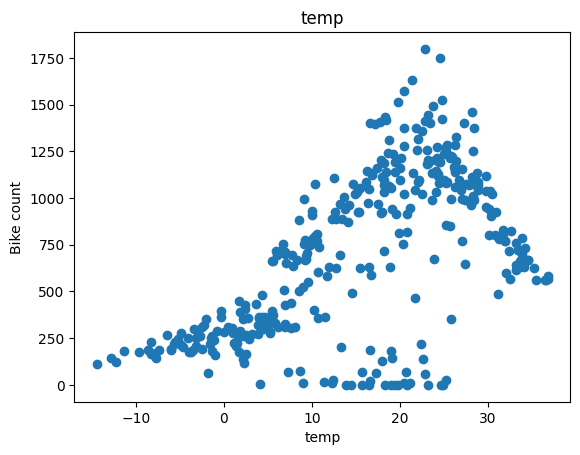

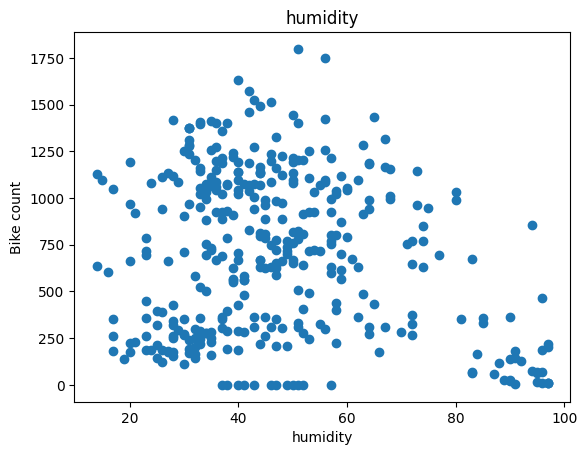

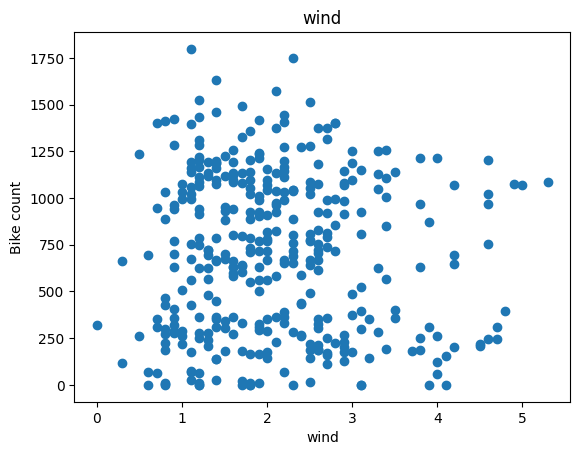

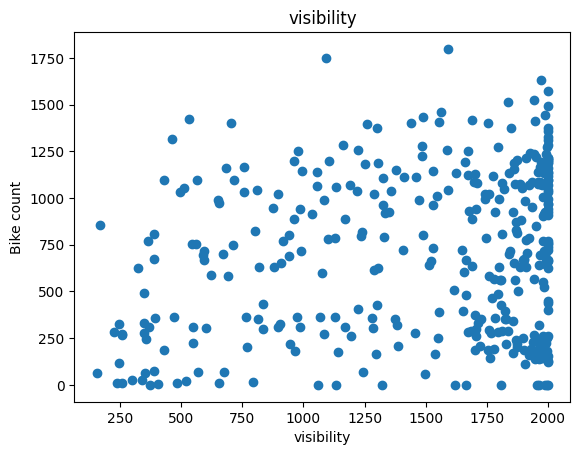

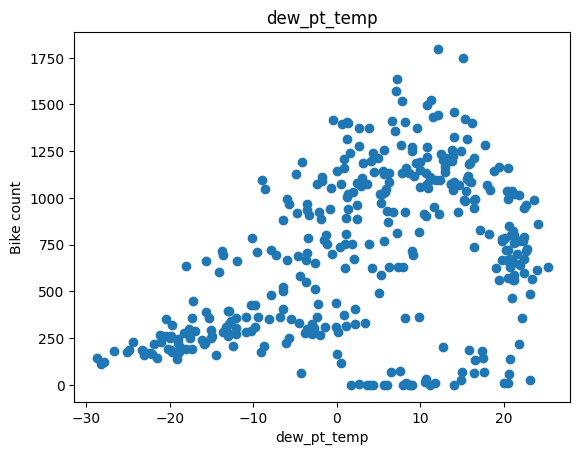

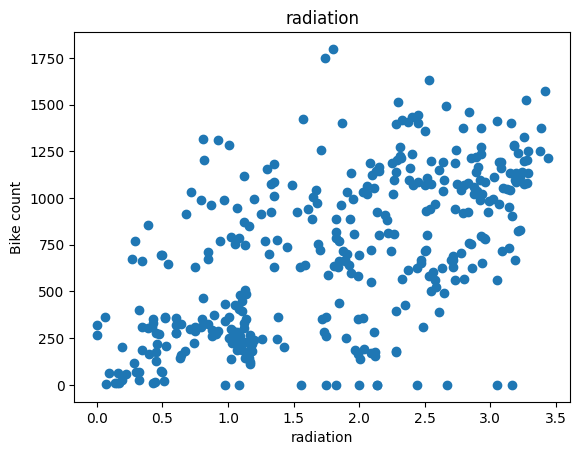

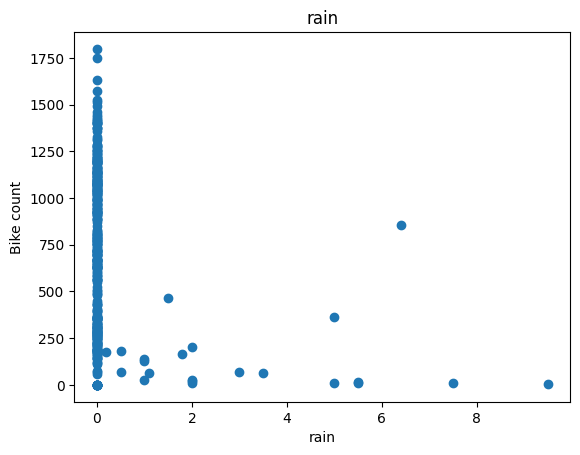

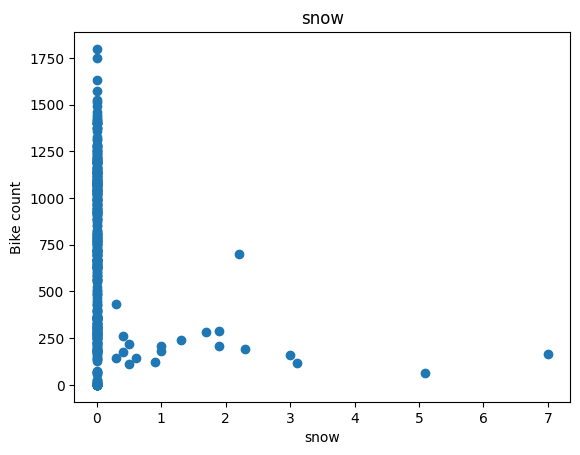

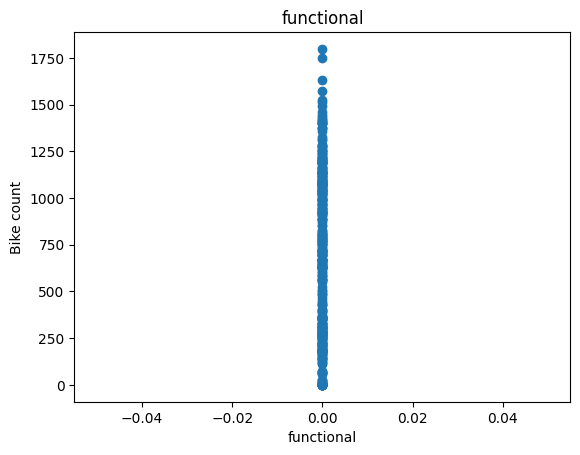

In [14]:
for label in df.columns[1:]:
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel("Bike count")
  plt.show()

In [15]:
df=df.drop(["functional","rain","snow"],axis=1)

In [16]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation
12,449,1.7,23,1.4,2000,-17.2,1.11
36,479,4.3,41,1.3,1666,-7.8,1.09
60,333,5.8,85,1.7,349,3.4,0.43
84,393,-0.3,38,4.8,1823,-12.9,1.11
108,321,-2.3,25,0.0,1962,-19.7,0.00


# Training


In [52]:
train,val,test=np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [53]:
def get_xy(dataframe,y_label,x_labels=None):
  dataframe=copy.deepcopy(dataframe)
  if x_labels is None:
    X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels)==1:
      X=dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X=dataframe[x_labels].values
  y= dataframe[y_label].values.reshape(-1,1)
  data=np.hstack((X,y))

  return data,X,y

In [54]:
trainz, X_train_temp, y_train_temp=get_xy(train,"bike_count",["temp"])
validz, X_valid_temp, y_valid_temp=get_xy(val,"bike_count",["temp"])
testz, X_test_temp, y_test_temp=get_xy(test,"bike_count",["temp"])


In [55]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp,y_train_temp)

LinearRegression()

In [56]:
print(temp_reg.coef_,temp_reg.intercept_)
temp_reg.score(X_test_temp,y_test_temp)

[[19.62925521]] [375.5447384]


0.41926430977469376

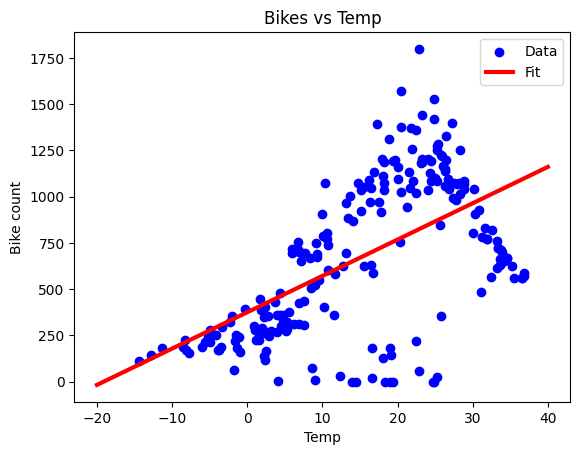

In [57]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [44]:
train,val,test=np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [45]:
traina, X_train_all, y_train_all=get_xy(train,"bike_count",df.columns[1:])
valida, X_valid_all, y_valid_all=get_xy(val,"bike_count",df.columns[1:])
testa, X_test_all, y_test_all=get_xy(test,"bike_count",df.columns[1:])

In [46]:
all_reg=LinearRegression()
all_reg.fit(X_train_all,y_train_all)

LinearRegression()

In [47]:
all_reg.score(X_test_all,y_test_all)

0.4215310922300294

# Regression with Neural Net

In [60]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [64]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])
# has backpropogation per neuron but this does not apply to sci kit linear model's linear regresson

In [65]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [68]:
def plot_loss(history):
    """
    Plots the training and validation loss.

    Parameters:
    - history: The history object returned by the `fit` method of a Keras model.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [67]:
history=temp_nn_model.fit(
    X_train_temp.reshape(-1),
    y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_temp,y_valid_temp)
)

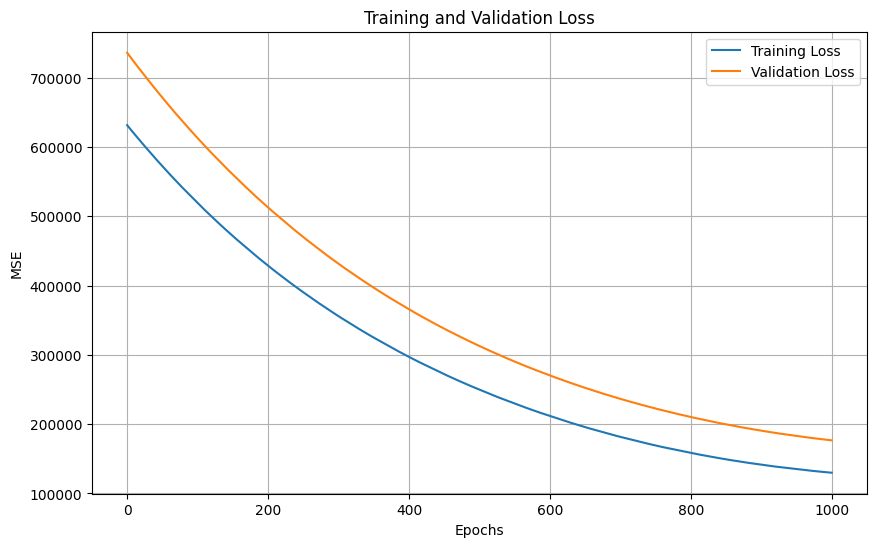

In [69]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


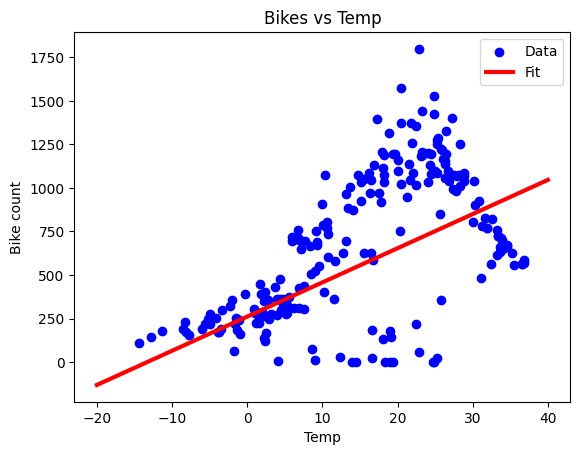

In [70]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

# Neural Net!

In [78]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mean_squared_error')

In [79]:
history=nn_model.fit(X_train_temp,y_train_temp,validation_data=(X_valid_temp,y_valid_temp),verbose=0,epochs=100)

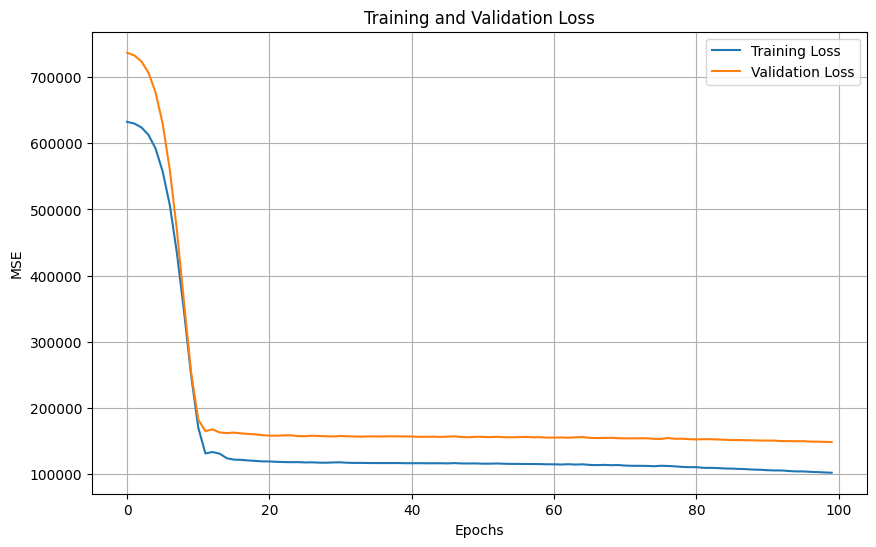

In [80]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


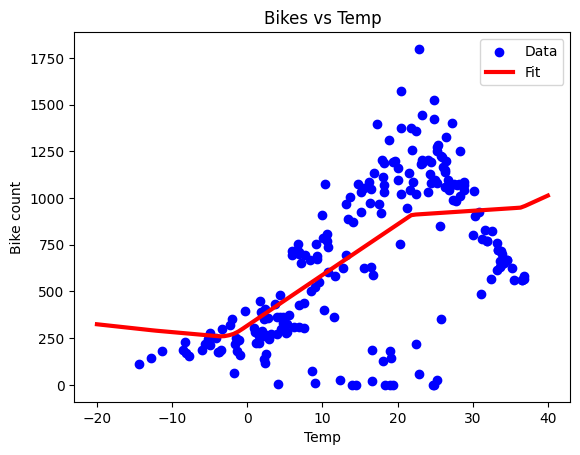

In [83]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike count")
plt.xlabel("Temp")
plt.show()

#no longer linear, like single neuron or other above models